In [1]:
#Este software foi implementado usando um ambiente Debian 9.9,
#com Python 3 na versão 3.5.3, Pandas 0.19.2, NumPy 1.12.1,
#Scikit-Learn 0.18, Matplotlib 2.0.0, Xgboost 0.90 e
#Jupyter Notebook 4.2.3
#Compatibilidade com versões posteriores não é garantida

#carrega as bibliotecas a serem adicionadas

import os
import pandas as pd 
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.neural_network import BernoulliRBM, MLPClassifier

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

#RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

#XGBoost
import xgboost as xgb

#suprimir as warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
ndxOriginal = pd.read_csv("^NDX.csv",parse_dates=['Date'],index_col='Date')
ndx = ndxOriginal['2010':]
ndx['Return'] = np.log(ndx.Close.shift(-1) / ndx.Close)*100
#ndx['Var.Day(%)'] = ((ndx['Close']-ndx['Open'])/ndx['Open'])*100

ndx['Class'] = np.where(ndx['Return']>=0,1,0)
ndx['Class'] = ndx['Class'].astype('int')

ndx['OpenPct']  = ndx['Open'].pct_change()
ndx['HighPct']  = ndx['High'].pct_change()
ndx['LowPct']   = ndx['Low'].pct_change()
ndx['ClosePct'] = ndx['Close'].pct_change()

In [3]:
#ndxData = ndx[['OpenPct','HighPct','LowPct','ClosePct','Class']].dropna()
ndxData = ndx[['OpenPct','HighPct','LowPct','ClosePct']].dropna()

n_dias = 30
#ndxData = pd.DataFrame(index=ndxData.index)
for i in range(n_dias):
    shiftedValues = ndx[['OpenPct','HighPct','LowPct','ClosePct']].shift(periods=i+1).add_suffix('_d-'+str(i+1))
    ndxData = ndxData.join(shiftedValues)

ndxData = ndxData.join(ndx['Class']).dropna()

train_data = np.array(ndxData[:'2018/01/01'].iloc[:,:-1])
#class_data = np.where(ndxData[:'2018/01/01'].iloc[:,-1]=='Alta',1,0)
class_data = np.array(ndxData[:'2018/01/01'].iloc[:,-1]).astype(int)

In [4]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
scores={}
n_features = train_data.shape[1]
scale = 1 / (n_features * train_data.var())
for kernelName in kernels:
    clf = SVC(kernel=kernelName,gamma=scale)
    score = cross_val_score(clf, train_data, class_data, cv=5)
    print('Score médio para '+kernelName+": "+str(np.mean(score)))
    scores[kernelName]=score
print(scores)

Score médio para linear: 0.5529770062433379
Score médio para poly: 0.5549642150144664
Score médio para rbf: 0.5393406426069743
Score médio para sigmoid: 0.5438784833257195
{'linear': array([0.55276382, 0.5530303 , 0.5530303 , 0.5530303 , 0.5530303 ]), 'poly': array([0.58542714, 0.55050505, 0.55050505, 0.53535354, 0.5530303 ]), 'rbf': array([0.55276382, 0.52272727, 0.53282828, 0.5479798 , 0.54040404]), 'sigmoid': array([0.56030151, 0.54040404, 0.52777778, 0.54545455, 0.54545455])}


In [5]:
clf = RandomForestClassifier()

n_estimators = [int(x) for x in range(50,525,25)]
max_depth = [int(x) for x in range(2,22,2)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_search_param = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
print(random_search_param)

rf_random = RandomizedSearchCV(clf, param_distributions = random_search_param, n_iter = 50, cv = 3, random_state=0, n_jobs = -1, verbose=10)
# Fit the random search model
rf_random.fit(train_data, class_data)

{'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.0min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [6]:
print(rf_random.best_params_)
clf = rf_random.best_estimator_
score = cross_val_score(clf, train_data, class_data, cv = 5)
print(score)
print(np.mean(score))

{'n_estimators': 450, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 8, 'bootstrap': True}
[0.53517588 0.5530303  0.54040404 0.5530303  0.5479798 ]
0.5459240647682859


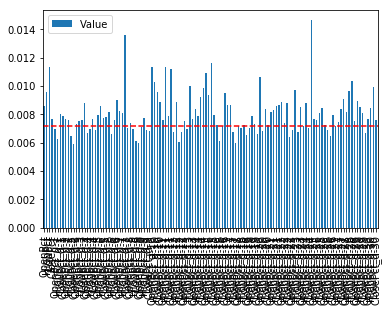

Features com valor acima do threshold:
Index(['OpenPct', 'HighPct', 'LowPct', 'ClosePct', 'LowPct_d-1',
       'ClosePct_d-1', 'OpenPct_d-2', 'HighPct_d-2', 'OpenPct_d-3',
       'HighPct_d-3', 'LowPct_d-3', 'ClosePct_d-3', 'LowPct_d-4',
       'OpenPct_d-5', 'HighPct_d-5', 'LowPct_d-5', 'ClosePct_d-5',
       'OpenPct_d-6', 'LowPct_d-6', 'ClosePct_d-6', 'OpenPct_d-7',
       'HighPct_d-7', 'LowPct_d-7', 'OpenPct_d-8', 'HighPct_d-9',
       'OpenPct_d-10', 'HighPct_d-10', 'LowPct_d-10', 'ClosePct_d-10',
       'OpenPct_d-11', 'HighPct_d-11', 'LowPct_d-11', 'ClosePct_d-11',
       'HighPct_d-12', 'OpenPct_d-13', 'LowPct_d-13', 'ClosePct_d-13',
       'OpenPct_d-14', 'HighPct_d-14', 'LowPct_d-14', 'ClosePct_d-14',
       'OpenPct_d-15', 'HighPct_d-15', 'LowPct_d-15', 'ClosePct_d-15',
       'OpenPct_d-16', 'LowPct_d-16', 'ClosePct_d-16', 'OpenPct_d-17',
       'HighPct_d-17', 'LowPct_d-18', 'HighPct_d-19', 'LowPct_d-19',
       'OpenPct_d-20', 'LowPct_d-20', 'ClosePct_d-20', 'OpenPct_d-2

In [7]:
clf.fit(train_data,class_data)
featureImportance = pd.DataFrame(index=ndxData.iloc[:,:-1].columns)
featureImportance['Value'] = 0

i = 0
for value in clf.feature_importances_:
    featureImportance.iloc[i,0]=value
    i+=1
    
ax = featureImportance.plot(kind='bar')
ax.axhline(y=np.quantile(featureImportance['Value'],0.3),color='r',linestyle='--')
plt.show()
print('Features com valor acima do threshold:')
important = featureImportance[featureImportance['Value']>=np.quantile(featureImportance['Value'],0.3)].index
print(important)

In [8]:
ndxImportant = ndxData[important]

train_data = np.array(ndxImportant)
class_data = np.array(ndxData.iloc[:,-1])

In [9]:
kernels = [ 'linear', 'poly', 'rbf', 'sigmoid']
scores={}
scale = 1 / (n_features * train_data.var())
clfSVM = []

X_train, X_test, y_train, y_test = train_test_split(train_data, class_data, test_size=0.3)

for kernelName in kernels:
    clf = SVC(kernel=kernelName,gamma=scale)
    score = cross_val_score(clf, train_data, class_data, cv=5)
    print('Score médio para '+kernelName+": "+str(np.mean(score)))
    scores[kernelName]=score
    clf.fit(X_train,y_train)
    clfSVM.append(clf)
print(scores)

Score médio para linear: 0.5545688444697042
Score médio para poly: 0.5562610797859497
Score médio para rbf: 0.5448302521984185
Score médio para sigmoid: 0.5494939490855628
{'linear': array([0.55485232, 0.55391121, 0.55391121, 0.55508475, 0.55508475]), 'poly': array([0.55907173, 0.55391121, 0.55179704, 0.55932203, 0.55720339]), 'rbf': array([0.55696203, 0.54122622, 0.54545455, 0.54872881, 0.53177966]), 'sigmoid': array([0.55274262, 0.54545455, 0.54334038, 0.56355932, 0.54237288])}


In [10]:
clf = RandomForestClassifier()
n_estimators = [int(x) for x in range(50,525,25)]
max_depth = [int(x) for x in range(2,22,2)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_search_param = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
print(random_search_param)

rf_random = RandomizedSearchCV(clf, param_distributions = random_search_param, n_iter = 50, cv = 3, random_state=0, n_jobs = -1, verbose=10)
# Fit the random search model
rf_random.fit(train_data, class_data)

{'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [11]:
print(rf_random.best_params_)
clfRF = rf_random.best_estimator_
score = cross_val_score(clfRF, train_data, class_data, cv = 5)
print(score)
print(np.mean(score))

{'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 2, 'bootstrap': True}
[0.55907173 0.55179704 0.54756871 0.55508475 0.55508475]
0.5537213944023541


In [12]:
#MLP
clfMLP = MLPClassifier(random_state=1)

solver = ['lbfgs', 'sgd', 'adam']
alpha= [0.1,0.01,0.001,0.0001,0.00001]
hidden_layer_sizes=[(x**2,int((x**2)/2)) for x in range(5,11,1)]

random_search_param = {'solver': solver,
                       'alpha': alpha,
                       'hidden_layer_sizes': hidden_layer_sizes}
print(random_search_param)

MLP_random = RandomizedSearchCV(clfMLP, param_distributions = random_search_param, n_iter = 50, cv = 3, random_state=0, n_jobs = -1, verbose=10)
# Fit the random search model
MLP_random.fit(train_data, class_data)

print(MLP_random.best_params_)
clfMLP = MLP_random.best_estimator_
score = cross_val_score(clfMLP, train_data, class_data, cv = 5)
print(score)
print(np.mean(score))

{'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.1, 0.01, 0.001, 0.0001, 1e-05], 'hidden_layer_sizes': [(25, 12), (36, 18), (49, 24), (64, 32), (81, 40), (100, 50)]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   45.3s finished


{'solver': 'sgd', 'hidden_layer_sizes': (81, 40), 'alpha': 0.1}
[0.55485232 0.55391121 0.55391121 0.55508475 0.55508475]
0.5545688444697042


In [13]:
param_grid = {
        'silent': [True],
        'max_depth': [5, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [int(x) for x in range(50,550,50)],
        'objective': ['binary:logistic']}

fit_params = {'eval_metric': 'auc',
              'early_stopping_rounds': 10,
             'eval_set': [(X_test, y_test)]}

xg_cls_default = xgb.XGBClassifier()

rs_clf = RandomizedSearchCV(xg_cls_default, param_grid, n_iter=250,fit_params=fit_params,
                            n_jobs=-1, verbose=2, cv=3, refit=True, random_state=0)

rs_clf.fit(train_data, class_data)

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  2.8min finished


[0]	validation_0-auc:0.571596
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.61923
[2]	validation_0-auc:0.634968
[3]	validation_0-auc:0.635849
[4]	validation_0-auc:0.6365
[5]	validation_0-auc:0.642323
[6]	validation_0-auc:0.643316
[7]	validation_0-auc:0.654929
[8]	validation_0-auc:0.657378
[9]	validation_0-auc:0.658757
[10]	validation_0-auc:0.661218
[11]	validation_0-auc:0.665545
[12]	validation_0-auc:0.671934
[13]	validation_0-auc:0.671922
[14]	validation_0-auc:0.674021
[15]	validation_0-auc:0.677954
[16]	validation_0-auc:0.682848
[17]	validation_0-auc:0.683909
[18]	validation_0-auc:0.685369
[19]	validation_0-auc:0.68512
[20]	validation_0-auc:0.690174
[21]	validation_0-auc:0.695442
[22]	validation_0-auc:0.697098
[23]	validation_0-auc:0.696206
[24]	validation_0-auc:0.695924
[25]	validation_0-auc:0.69933
[26]	validation_0-auc:0.700263
[27]	validation_0-auc:0.70089
[28]	validation_0-auc:0.703138
[29]	validation_0-auc:0.703078
[30]	validation_0-auc:

[259]	validation_0-auc:0.84333
[260]	validation_0-auc:0.843836
[261]	validation_0-auc:0.844617
[262]	validation_0-auc:0.844536
[263]	validation_0-auc:0.8453
[264]	validation_0-auc:0.846056
[265]	validation_0-auc:0.846104
[266]	validation_0-auc:0.846346
[267]	validation_0-auc:0.84686
[268]	validation_0-auc:0.847624
[269]	validation_0-auc:0.847777
[270]	validation_0-auc:0.847922
[271]	validation_0-auc:0.848316
[272]	validation_0-auc:0.848847
[273]	validation_0-auc:0.84978
[274]	validation_0-auc:0.850045
[275]	validation_0-auc:0.85029
[276]	validation_0-auc:0.850994
[277]	validation_0-auc:0.851428
[278]	validation_0-auc:0.851855
[279]	validation_0-auc:0.852598
[280]	validation_0-auc:0.853234
[281]	validation_0-auc:0.853374
[282]	validation_0-auc:0.853777
[283]	validation_0-auc:0.853921
[284]	validation_0-auc:0.854122
[285]	validation_0-auc:0.854508
[286]	validation_0-auc:0.855071
[287]	validation_0-auc:0.85565
[288]	validation_0-auc:0.855932
[289]	validation_0-auc:0.856278
[290]	validatio

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params={'eval_metric': 'auc', 'early_stopping_rounds': 10, 'eval_set': [(array([[ 0.01047,  0.0095 , ...,  0.00765,  0.00829],
       [ 0.00417,  0.00091, ...,  0.01019,  0.01504],
       ...,
       [ 0.0075 ,  0.00098, ...,  0.00079,  0.00806],
       [-0.02025, -0.0199 , ...,  0.00954, -0.00687]]), array([0, 1, ..., 1, 0]))]},
          iid='warn', n_iter=250, n_jobs=-1,
          param_distributions={'silent': [True], 'max_depth': [5, 10, 15, 20], 'learning_rate': [0.001

In [14]:
print(rs_clf.best_params_)
xg_cls = rs_clf.best_estimator_
score = cross_val_score(xg_cls, train_data, class_data, cv = 5)
print(score)
print(np.mean(score))

{'subsample': 1.0, 'silent': True, 'reg_lambda': 100.0, 'objective': 'binary:logistic', 'n_estimators': 350, 'min_child_weight': 1.0, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4}
[0.56118143 0.5243129  0.55602537 0.56779661 0.55932203]
0.5537276690103462


In [33]:
#inicialização do Dataframe com os dados de 2019
train_data = np.array(ndxData[important])
Df = pd.DataFrame(ndx)[ndxData.index[0]:]
Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100

#Random Forest
preds = clfRF.predict(train_data)
Df['Predicted_Signal_rf'] = preds
print(preds)
#Df['Predicted_Signal_rf'] = Df['Predicted_Signal_rf'].shift(-1)
Df['Strategy_Return_rf'] = Df.Return * Df.Predicted_Signal_rf

#multilayer perceptron
preds = clfMLP.predict(train_data)
Df['Predicted_Signal_mlp'] = preds
#Df['Predicted_Signal_mlp'] = Df['Predicted_Signal_mlp']#.shift(-1)
Df['Strategy_Return_mlp'] = Df.Return * Df.Predicted_Signal_mlp

#XGBoost Tree
preds = xg_cls.predict_proba(train_data)[:,1]
Df['Predicted_Signal_xg'] = preds>=0.5
Df['Predicted_Signal_xg_safe'] = preds>=0.7
Df['Predicted_Signal_xg_aggro'] = preds>=0.3

Df['Strategy_Return_xg'] = Df.Return * Df.Predicted_Signal_xg

#SVMs
SVMPredict = []
for i,clf in enumerate(clfSVM):
    preds = clf.predict(train_data)
    kernelPredict = 'Strategy_Return_'+kernels[i]
    SVMPredict.append(kernelPredict)
    Df[kernelPredict] = preds
    Df[kernelPredict] = Df.Return * Df[kernelPredict]#.shift(-1)
    
#pseudorandom
Df['Strategy_Return_PseudoRandom'] = Df.Return * np.random.random_integers(low=0, high=1, size=Df.Return.shape[0])

[1 1 1 ... 1 1 1]


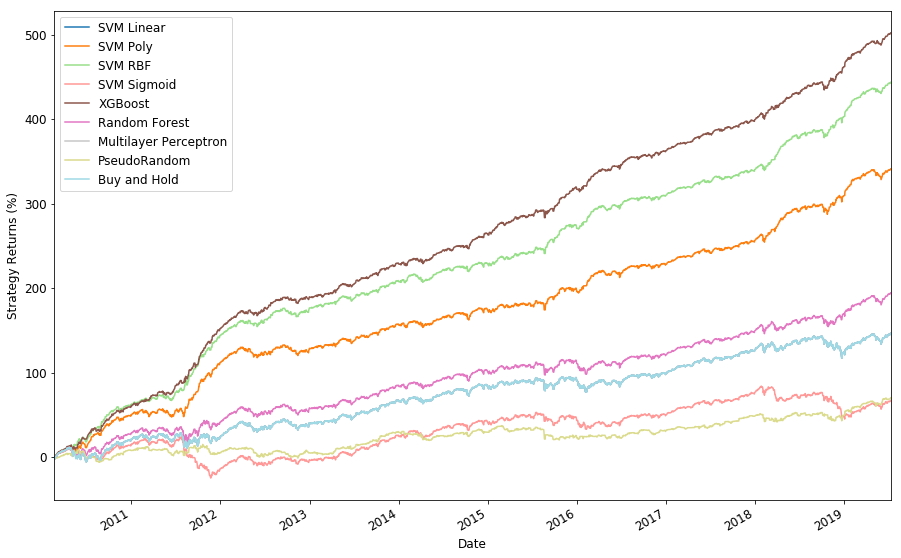

In [34]:
my_labels=['SVM Linear', 'SVM Poly', 'SVM RBF', 'SVM Sigmoid',
          'XGBoost', 'Random Forest', 'Multilayer Perceptron', 'PseudoRandom',
          'Buy and Hold']

columnsToPlot = SVMPredict+['Strategy_Return_xg','Strategy_Return_rf',
                 'Strategy_Return_mlp','Strategy_Return_PseudoRandom','Return']

plt.rcParams.update({'font.size': 12})

Df[columnsToPlot].cumsum().plot(figsize=(15,10),cmap='tab20')
plt.ylabel("Strategy Returns (%)")
plt.legend(labels=my_labels) 
plt.show()

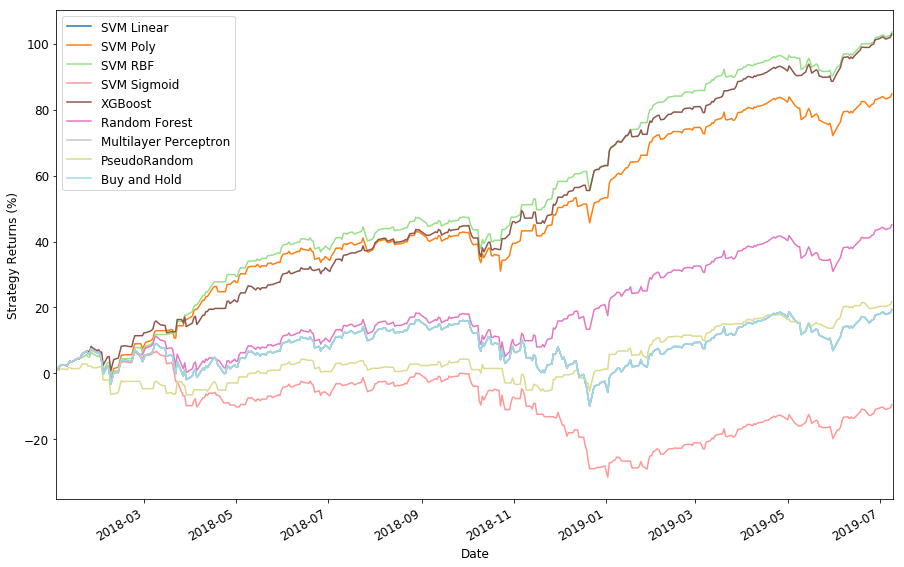

In [35]:
Df[columnsToPlot]['2018':].cumsum().plot(figsize=(15,10),cmap='tab20')
plt.ylabel("Strategy Returns (%)")
plt.legend(labels=my_labels) 
plt.show()

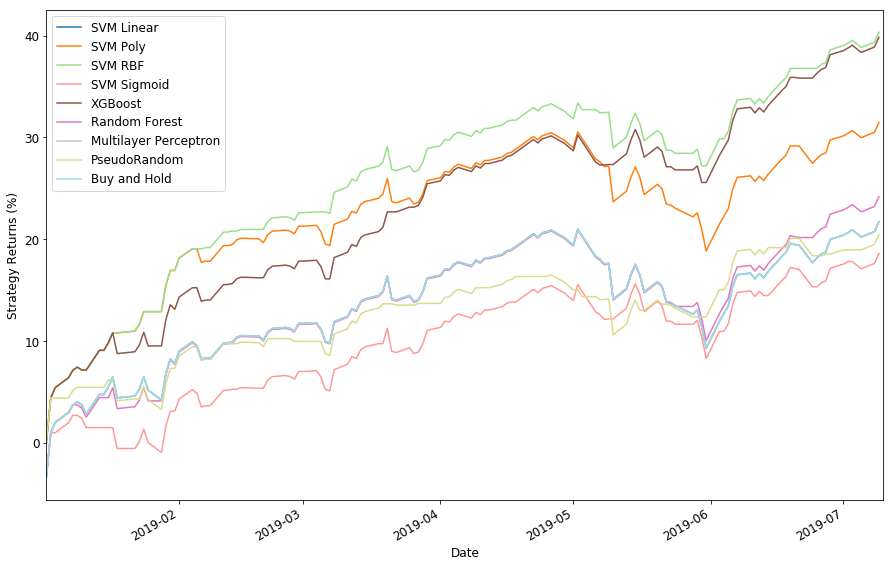

In [36]:
Df[columnsToPlot]['2019':].cumsum().plot(figsize=(15,10),cmap='tab20')
plt.ylabel("Strategy Returns (%)")
plt.legend(labels=my_labels) 
plt.show()

In [37]:
Df['Predicted_Signal_GroundTruth'] = Df.Class
Df['Strategy_Return_GroundTruth'] = Df.Return * Df.Predicted_Signal_GroundTruth#.shift(-1)

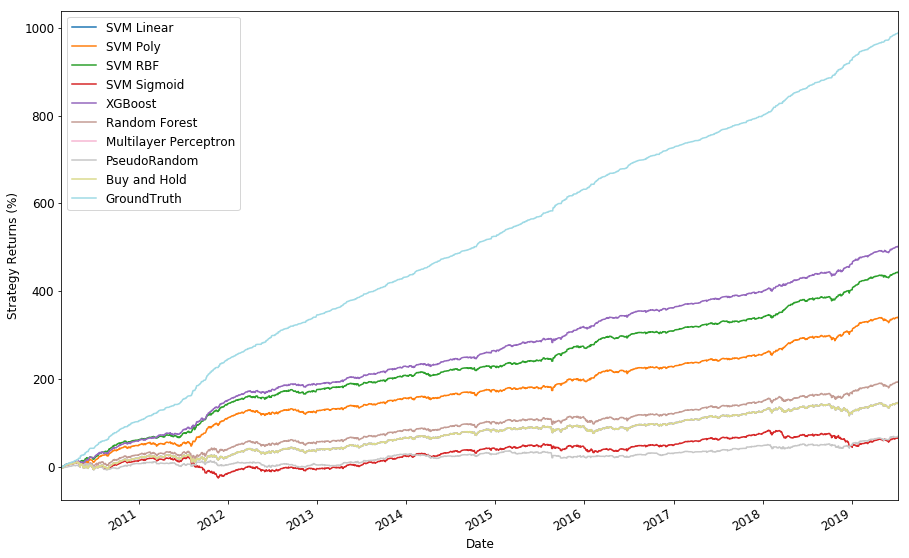

In [38]:
my_labels=['SVM Linear', 'SVM Poly', 'SVM RBF', 'SVM Sigmoid',
          'XGBoost', 'Random Forest', 'Multilayer Perceptron', 'PseudoRandom',
          'Buy and Hold', 'GroundTruth']

columnsToPlot = SVMPredict+['Strategy_Return_xg','Strategy_Return_rf',
                 'Strategy_Return_mlp','Strategy_Return_PseudoRandom','Return','Strategy_Return_GroundTruth']

plt.rcParams.update({'font.size': 12})

Df[columnsToPlot].cumsum().plot(figsize=(15,10),cmap='tab20')
plt.ylabel("Strategy Returns (%)")
plt.legend(labels=my_labels) 
plt.show()

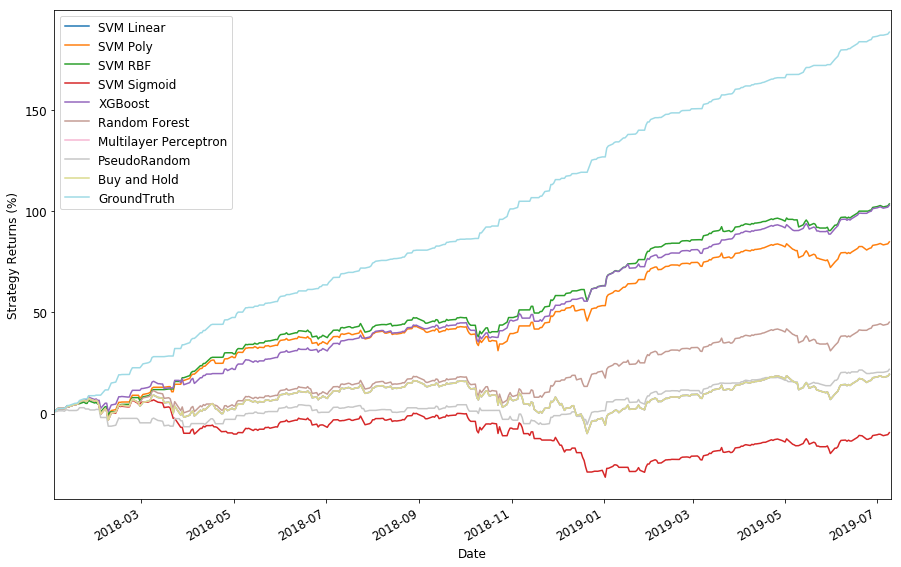

In [39]:
my_labels=['SVM Linear', 'SVM Poly', 'SVM RBF', 'SVM Sigmoid',
          'XGBoost', 'Random Forest', 'Multilayer Perceptron', 'PseudoRandom',
          'Buy and Hold', 'GroundTruth']

columnsToPlot = SVMPredict+['Strategy_Return_xg','Strategy_Return_rf',
                 'Strategy_Return_mlp','Strategy_Return_PseudoRandom','Return','Strategy_Return_GroundTruth']

plt.rcParams.update({'font.size': 12})

Df[columnsToPlot]['2018':].cumsum().plot(figsize=(15,10),cmap='tab20')
plt.ylabel("Strategy Returns (%)")
plt.legend(labels=my_labels) 
plt.show()

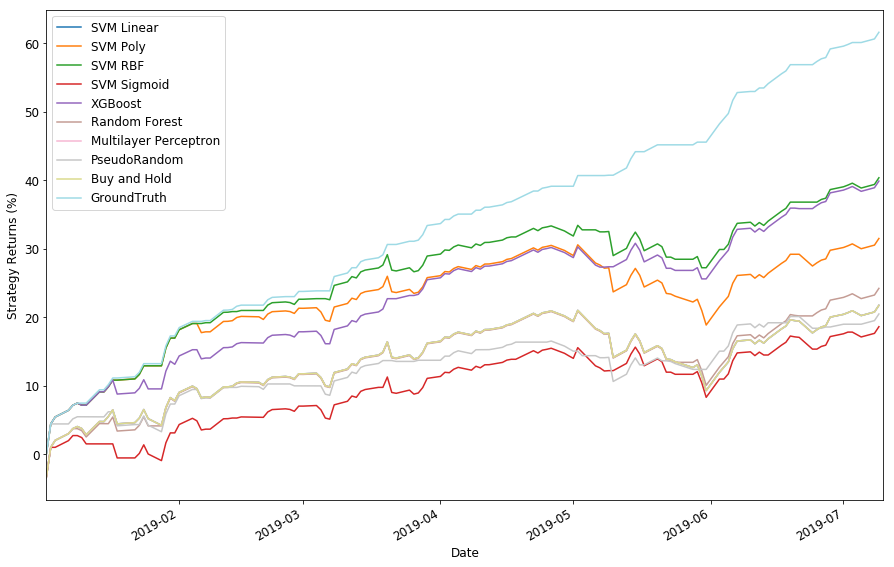

In [40]:
my_labels=['SVM Linear', 'SVM Poly', 'SVM RBF', 'SVM Sigmoid',
          'XGBoost', 'Random Forest', 'Multilayer Perceptron', 'PseudoRandom',
          'Buy and Hold', 'GroundTruth']

columnsToPlot = SVMPredict+['Strategy_Return_xg','Strategy_Return_rf',
                 'Strategy_Return_mlp','Strategy_Return_PseudoRandom','Return','Strategy_Return_GroundTruth']

plt.rcParams.update({'font.size': 12})

Df[columnsToPlot]['2019':].cumsum().plot(figsize=(15,10),cmap='tab20')
plt.ylabel("Strategy Returns (%)")
plt.legend(labels=my_labels) 
plt.show()